## Computer Vision Project 2 - Game of Blackjack
- Kacper Trębacz

- Jan Gruszczyński

# Notebook role:

In this notebook we generate an artificial dataset of labeled tokens on random backgrounds. We do it in the following way: 
We take cards prepared in a card_cutter notebook, we apply a random sequence of transformation on them using a wonderful library -imgaug, then we copy those cards onto random backgrounds. The task is rather not trivial due to difficulty in determination of final coordinates position of bounding boxes that contain card symbols.

Example:

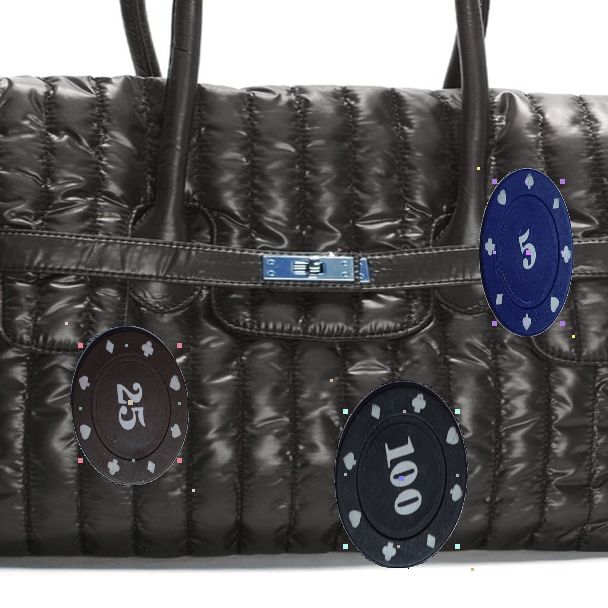

In [50]:
generator = Generator(608, 608)
generator.generate_image(img2, load_cards(), 1, "example")

In [2]:
import cv2
from IPython.display import display, HTML
import glob
from random import randrange, choice, sample
try:
    import Image
except ImportError:
    from PIL import Image
import numpy as np
from pprint import pprint as pp
import json

In [3]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [5]:
#Utils
def random_color():
    return [randrange(120, 255), 
            randrange(120, 255), 
            randrange(120, 255)]

# https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Pass only copies!!!!!!!!!!!!!!!!!!
    img = img.copy()
    img_overlay = img_overlay.copy()
    alpha_mask = alpha_mask.copy()
    
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        print("XD")
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha
    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop
    return img

# https://leetcode.com/problems/rectangle-overlap/solution/
def isRectangleOverlap(rec1, rec2):
    def intersect(p_left, p_right, q_left, q_right):
        return min(p_right, q_right) > max(p_left, q_left)
    return (intersect(rec1[0], rec1[2], rec2[0], rec2[2]) and # width > 0
            intersect(rec1[1], rec1[3], rec2[1], rec2[3]))    # height > 0
 
    return True

In [8]:
for path in glob.glob('./photos/tokens/*.png'):
    print(path)

./photos/tokens/50_b.png
./photos/tokens/100_a.png
./photos/tokens/5_a.png
./photos/tokens/5_b.png
./photos/tokens/25_b.png
./photos/tokens/50_a.png
./photos/tokens/100_b.png
./photos/tokens/25_a.png


In [13]:
#BOUNDING BOXES HAVE TO BE MADE OF FOUR POINTS
def load_cards():
    my_tokens = []
    for path in glob.glob('./photos/tokens/*.png'):
        a_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        a_img = cv2.resize(a_img, (250,250), interpolation = cv2.INTER_AREA)
        # Blacking pixels where alpha=0
        a_img[a_img[:,:, 3] == 0] = [0,0,0,0]
        a_img = a_img[:,:, :3] # Converting to RGB
        shape = a_img.shape
        
        KP = []
        KP.append(ia.Keypoint(x=shape[1]/2, y=20))
        KP.append(ia.Keypoint(x=shape[1]/2, y=shape[0]-20))
        KP.append(ia.Keypoint(x=40, y=shape[0]/2))
        KP.append(ia.Keypoint(x=shape[1]-30, y=shape[0]/2))
        
        cardKP = ia.KeypointsOnImage(KP, shape=a_img.shape)

        my_tokens.append(Card(a_img, cardKP, card_name=path.split("/")[3].split(".")[0].split("_")[0], 
                              num_of_bounded_boxes=1))
    return my_tokens

my_cards = load_cards()
print(my_cards)
list_of_card_names = tuple(["5", "25", "50", "100"])
# for card in my_cards:
#     card.display_me()

[50, 100, 5, 5, 25, 50, 100, 25]


In [14]:
class Card:
    def __init__(self, card_array, KP, card_name, num_of_bounded_boxes) -> None:
        super().__init__()
        self.card_array = card_array
        self.KP = KP
        self.KP_background = None
        self.bounding_box = None
        self.card_name = card_name
        self.yolo_description = None
        self.box_centers = []
        self.on_what_background = None
        self.yolo_labels = []
        self.num_of_bounded_boxes = num_of_bounded_boxes
        
    def __repr__(self) -> str:
        return str(self.card_name) #+ str( self.KP_background)
        
    def display_me(self):
        img_to_display = self.KP.draw_on_image(self.card_array, size=3, color=[0,0,255])
        display(Image.fromarray(img_to_display))
    
    def augument_me(self, edit_me=True):
        transformation = random_transformation()
        if not edit_me:
            augumented_card, augKP = transformation(image=self.card_array, keypoints=self.KP)
            return augumented_card, augKP
        else:
            self.card_array, self.KP = transformation(image=self.card_array, keypoints=self.KP)
#             self.display_me()
            return self.card_array, self.KP
        
    def KP_background_to_bounding_box(self):
        bounding_box_KP = []
        for _ in range(0, self.num_of_bounded_boxes):
            
            point_list = []
            for KP in range(0, 4):
                KP = self.KP_background.keypoints[KP+(4*_)]
                point_list.append((KP.x, KP.y))

            x_min = min(point[0] for point in point_list)
            x_max = max(point[0] for point in point_list)
            y_min = min(point[1] for point in point_list)
            y_max = max(point[1] for point in point_list)
#             print(self.box_centers)
            self.box_centers.append(((x_max+x_min)/2, (y_max+y_min)/2))
            bg_width = self.on_what_background.background_array.shape[1]
            bg_height = self.on_what_background.background_array.shape[0]
            label = {"x_center":((x_max+x_min)/2)/bg_width, "y_center":((y_max+y_min)/2)/bg_height, 
                     "width":(x_max-x_min)/bg_width, "height":(y_max-y_min)/bg_height,
                    "index": list_of_card_names.index(self.card_name)}
            self.yolo_labels.append(label)
#             print(label)
            
            bounding_box_KP.append(ia.Keypoint(x_min, y_min))
            bounding_box_KP.append(ia.Keypoint(x_min, y_max))
            bounding_box_KP.append(ia.Keypoint(x_max, y_min))
            bounding_box_KP.append(ia.Keypoint(x_max, y_max))
            
        self.box_centers = ia.KeypointsOnImage([ia.Keypoint(x, y) for x,y in self.box_centers], shape=self.KP_background.shape)
#         print(bounding_box_KP)
        self.bounding_box = ia.KeypointsOnImage(bounding_box_KP, shape=self.KP_background.shape)

In [15]:
class Background:
    def __init__(self, background_array) -> None:
        super().__init__()
        self.cards = []
        self.taken_rectangles = []
        self.background_array = background_array
        
        
    def copy_card_randomly_onto_me_without_overlap(self, card):
        background_shape = self.background_array.shape
        card_shape = card.card_array.shape
        
        assert background_shape[1] > card_shape[1]
        assert background_shape[0] > card_shape[0]
        x = randrange(0, background_shape[1]-card_shape[1])
        y = randrange(0, background_shape[0]-card_shape[0])

        wanna_be_region =  [x, y, x+card_shape[1], y+card_shape[0]]

        for taken_rectangle in self.taken_rectangles:
            taken_region = [taken_rectangle.keypoints[0].x, taken_rectangle.keypoints[0].y, 
                            taken_rectangle.keypoints[1].x, taken_rectangle.keypoints[1].y]

            if isRectangleOverlap(wanna_be_region, taken_region):
                return False
        
        self._copy_card_onto_me(card, x, y, True)
        return True
    
        
    def _copy_card_onto_me(self, card, x, y, edit_me=True):
        # Creating rgba of card array to copy with alpha channel so that black background is invisible
        alpha = np.sum(card.card_array, axis=-1) > 0
        alpha = np.uint8(alpha * 255)
        rgba = np.dstack((card.card_array, alpha))

        
        alpha_mask = rgba[:, :, 3] / 255.0
        img_result = self.background_array[:, :, :3].copy()
        img_overlay = rgba[:, :, :3]
        
        if edit_me:
            self.background_array = overlay_image_alpha(img_result, img_overlay, x=x, y=y, alpha_mask=alpha_mask)
            
            card.KP_background = ia.KeypointsOnImage([ia.Keypoint(x=kp.x+x,y=kp.y+y) for kp in card.KP.keypoints], 
                                                shape=self.background_array.shape)
            
            card_bounding_keypoints =  ia.KeypointsOnImage([ia.Keypoint(x=x, y=y),
                                                            ia.Keypoint(x=x+img_overlay.shape[1], y=y+img_overlay.shape[0])
                                                            ], shape=self.background_array.shape)
            self.taken_rectangles.append(card_bounding_keypoints)
            self.cards.append(card)
            card.on_what_background = self
        else:
            #Should not edit KP and return eddited background
            pass

    def display_me(self):
        img_to_display = self.background_array.copy()
        for card in self.cards:
            img_to_display = card.KP_background.draw_on_image(img_to_display, size=3, color=random_color())
        for card in self.cards:
            if card.bounding_box is not None:
                img_to_display = card.bounding_box.draw_on_image(img_to_display, size=4, color=random_color())
            else:
                print("SHIT")
        for card in self.cards:
            if card.box_centers is not None:
                img_to_display = card.box_centers.draw_on_image(img_to_display, size=4, color=random_color())
        for taken_rectangle in self.taken_rectangles:
            img_to_display = taken_rectangle.draw_on_image(img_to_display, size=2, color=random_color())
        display(Image.fromarray(img_to_display))
        
    def bounding_boxes_for_cards(self):
        for card in self.cards:
            card.KP_background_to_bounding_box()
            
    def prepare_yolo_labels(self):
        labels = []
        for card in self.cards:
            labels.extend(card.yolo_labels)
        labels = sorted(labels, key=lambda x: x['index'])
        return tuple(labels)

    def _get_all_KP(self):
        all_KP = []
        for taken_rectangle in self.taken_rectangles:
            all_KP = all_KP + taken_rectangle.keypoints
        for card in self.cards:
            all_KP = all_KP + card.KP_background.keypoints
        return all_KP
    
    def _reset_KP_after_transformation(self, new_KP):
        new_taken_rectangles = []
        for taken_rectangle in range(0, len(self.taken_rectangles)):
            first = new_KP.pop(0)
            second = new_KP.pop(0)
            new_taken_rectangles.append(ia.KeypointsOnImage([first, second], shape=self.background_array.shape))
        self.taken_rectangles = new_taken_rectangles
        
        for card in self.cards:
            new_card_KP = []
            for _ in range(0, 4*card.num_of_bounded_boxes):
                new_card_KP.append(new_KP.pop(0))
            card.KP_background = ia.KeypointsOnImage(new_card_KP, shape=self.background_array.shape)
    
    def resize_me(self, width, height):
        transformation = iaa.Sequential([iaa.Resize({"height": height, "width": width})])
        self.background_array, new_KP = transformation(image=self.background_array, keypoints=self._get_all_KP())
        self._reset_KP_after_transformation(new_KP)

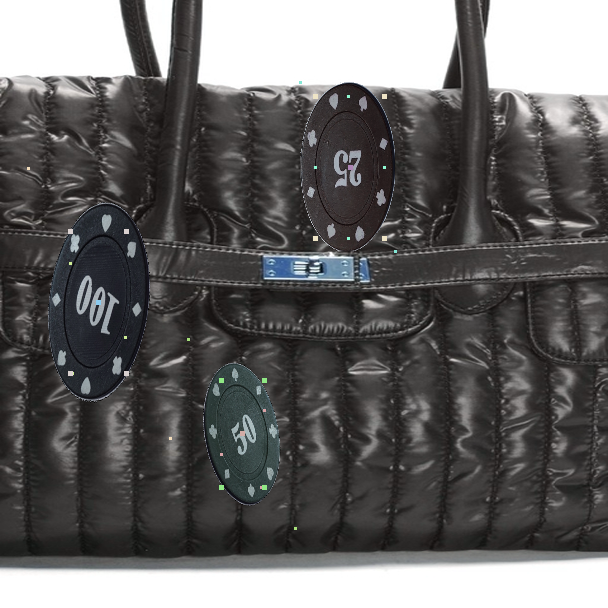

In [38]:
class Generator:
    def __init__(self, x, y) -> None:
        super().__init__()
        self.img_size_x = x
        self.img_size_y = y
        self.background = None
        
    def generate_image(self, background_img, cards, file_name, folder):
        background = Background(background_img)
        self.background = background
        
        background.resize_me(1600, 900)
        num_of_cards  = randrange(1, 6)
        cards = sample(cards, k=num_of_cards)
        
        for id_ in range(0, num_of_cards):
#             cards[id_].display_me()
            cards[id_].augument_me()
#             my_cards[id_].display_me()
            result  = background.copy_card_randomly_onto_me_without_overlap(cards[id_])
            if not result:
                continue
            
        background.resize_me(self.img_size_x, self.img_size_y)
        background.bounding_boxes_for_cards()
        labels = background.prepare_yolo_labels()
        self.save_label(labels, file_name, folder)
        
        cv2.imwrite(f'my_dataset_tokens/{folder}/images/{file_name}.jpg', background.background_array)
        
        background.display_me()
    
    def generate_dataset(self, backgrounds_path):
        dtd_dir="backgrounds/images/"
        bg_paths = []
        for subdir in glob.glob(dtd_dir+"/*"):
            for f in glob.glob(subdir+"/*.jpg"):
                bg_paths.append(f)
        #print(len(bg_paths)) # 5640
        for idik, path in enumerate(bg_paths[:700]):
            background_img = cv2.imread(path, cv2.IMREAD_COLOR)
            generator.generate_image(background_img, load_cards(), str(idik), "test")
        
        for idik, path in enumerate(bg_paths[700:]):
            background_img = cv2.imread(path, cv2.IMREAD_COLOR)
            generator.generate_image(background_img, load_cards(), str(idik), "train")

    def save_label(self, labels, file_name, folder):
        with open(f'my_dataset_tokens/{folder}/labels/{file_name}.txt', 'w+') as outfile:
            for label in labels:
                outfile.write(f"{label['index']} {label['x_center']} {label['y_center']} {label['width']} {label['height']}\n")


generator = Generator(608, 608)
generator.generate_image(img2, load_cards(), 1, "example")
# generator.generate_dataset("a")

In [28]:
img2 = glob.glob('./backgrounds/*.png')[0]
img2 = cv2.imread(img2, cv2.IMREAD_COLOR)
# display(Image.fromarray(img2))

In [21]:
transformations_random = [
        iaa.Sequential([
            iaa.Affine(
                scale=(0.6, 1.5),
                shear=(-32, 32),
                rotate=(-360, 360),
                mode="constant",
                cval=0,
                # mode=ia.ALL, 
                # cval=(0, 0),
                fit_output=True,)]),
        iaa.Sequential([
            iaa.Affine(
                scale=(0.4, 1.5),
                shear=(-32, 32),
                rotate=(-360, 360),
                mode="constant",
                cval=0,
                # mode=ia.ALL, 
                # cval=(0, 0),
                fit_output=True,)]),
        iaa.Sequential()
    
]
def random_transformation():
#         return transformations_random[2]
    return choice(transformations_random)